# Sentiment Analysis project.

I have requested data from **The Gdelt Project** (check info in the Readme), the goal is:

- Get an Analysis solution for spanish languaje. Compare it with the Sentiment metrics provided by Gdelt.
- Automate it in Google Cloud Platform.
- Plot results with a sweet Data Studio dashboard.

![ Alt text](https://thumbs.gfycat.com/LeafyVibrantFreshwatereel-small.gif)

- Well, this dataset cost me 2.15€, let's see what I've brought from BigQuery.

In [1]:
import pandas as pd
import re 

In [2]:
df = pd.read_csv("input/sentiment_analysis_160221.csv")
df

,Date,SourceCommonName,DocumentIdentifier,Sentiment,news_in_Spain
0,2019-01-24,ideal.es,https://www.ideal.es/economia/taxistas-barcelo...,-4.25,desempleo
1,2019-01-24,publico.es,https://www.publico.es/sociedad/proteccion-dat...,-3.22,desempleo
2,2019-01-24,regio7.cat,https://www.regio7.cat/arreu-catalunya-espanya...,-3.23,desempleo
3,2019-01-24,larioja.com,https://www.larioja.com/economia/taxistas-barc...,-4.25,desempleo
4,2019-01-24,vilaweb.cat,https://www.vilaweb.cat/noticies/els-taxistes-...,-3.26,desempleo
...,...,...,...,...,...
6792,2020-06-18,regiondigital.com,http://regiondigital.com/noticias/economia/329...,0.70,desempleo
6793,2020-06-18,elconfidencial.com,https://www.elconfidencial.com/espana/2020-06-...,-0.07,desempleo
6794,2020-06-18,elconfidencial.com,https://blogs.elconfidencial.com/economia/cons...,-0.13,desempleo
6795,2020-06-18,libertaddigital.com,https://www.libertaddigital.com/espana/2020-06...,-5.05,desempleo


- This is going to be fun. I have news in spanish, catalan, valencian ... Let's praise for there's no vask/gaellician

### 1. Data cleaning.

I need to extract as much info as possible from the column DocumentIdentifier, so I need to:
- Clean the https://www./ thing.
- Remove the name of the source.
- Create a list with the words belonging to the url.

In [3]:
df = pd.read_csv("input/sentiment_analysis_160221.csv")
df.drop(columns= 'news_in_Spain', inplace=True)
df.rename(columns={'Date':"date",'SourceCommonName':"source",'DocumentIdentifier':"url",
           "Sentiment":"gdelt_sentiment"},inplace=True)
df.columns

Index(['date', 'source', 'url', 'gdelt_sentiment'], dtype='object')

In [4]:
# removing the source from the url
df["url"] = [b.replace(a, '').strip() for a, b in zip(df["source"], df["url"])]
df.head(2)

,date,source,url,gdelt_sentiment
0,2019-01-24,ideal.es,https://www./economia/taxistas-barcelona-desco...,-4.25
1,2019-01-24,publico.es,https://www./sociedad/proteccion-datos-aepd-pe...,-3.22


In [5]:
# removing the internet protocol
deleting_list=["https://www./","http:///","https:",'http:',"//www./","///","//www./"]
for d in deleting_list:
    df["url"]= [x.replace(d,"") for x in df["url"]]
df.head(2)

,date,source,url,gdelt_sentiment
0,2019-01-24,ideal.es,economia/taxistas-barcelona-desconvocan-huelga...,-4.25
1,2019-01-24,publico.es,sociedad/proteccion-datos-aepd-perdona-multa-4...,-3.22


In [6]:
# create a list of strings without symbols
df["url"]= [re.split('-|_|/|!|\.', x)  for x in df["url"]] 
df.head(2)

,date,source,url,gdelt_sentiment
0,2019-01-24,ideal.es,"[economia, taxistas, barcelona, desconvocan, h...",-4.25
1,2019-01-24,publico.es,"[sociedad, proteccion, datos, aepd, perdona, m...",-3.22


In [7]:
def remove_numbers(list): 
    '''This function remove numbers from a list'''
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list

In [8]:
# let's remove the numbers
df["url"]= [remove_numbers(x) for x in df["url"]] 

# now let's remove the generated spaces
df["url"]=[' '.join(x).split() for x in df["url"]]

In [9]:
df["url"]

0       [economia, taxistas, barcelona, desconvocan, h...
1       [sociedad, proteccion, datos, aepd, perdona, m...
2       [arreu, catalunya, espanya, mon, els, taxistes...
3       [economia, taxistas, barcelona, desconvocan, h...
4       [noticies, els, taxistes, desconvoquen, la, va...
                              ...                        
6792    [noticias, economia, mas, de, clientes, recibe...
6793     [espana, mallorca, alemania, aplausos, turistas]
6794    [blogs, economia, consultorio, laboral, erte, ...
6795    [espana, la, salvaje, campana, de, acoso, y, d...
6796    [andalucia, andalucia, permitira, abrir, zonas...
Name: url, Length: 6797, dtype: object

### 2. Data processing.
- Remove articles and redundant words.
- Generate a column for each word counting their occurrences.

In [10]:
df["counter"]= [len(x) for x in df["url"]] #count words in every list

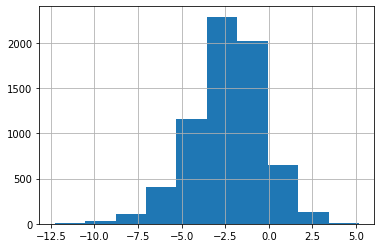

In [11]:
df["gdelt_sentiment"].hist()

- building a world count vector

In [12]:
def word_count(str_list):
    dictionary={}
    for s in set(str_list):
        dictionary[s]=str_list.count(s)
    return dictionary

In [13]:
df["word_count"]=[word_count(x) for x in df["url"]]
df[["gdelt_sentiment","word_count","counter"]]

,gdelt_sentiment,word_count,counter
0,-4.25,"{'html': 1, 'barcelona': 1, 'indefinida': 1, '...",8
1,-3.22,"{'html': 1, 'informatico': 1, 'mayor': 1, 'per...",14
2,-3.23,"{'html': 1, 'els': 1, 'mon': 1, 'espanya': 1, ...",10
3,-4.25,"{'html': 1, 'barcelona': 1, 'indefinida': 1, '...",8
4,-3.26,"{'els': 1, 'la': 1, 'taxistes': 1, 'vaga': 1, ...",7
...,...,...,...
6792,0.70,"{'html': 1, 'noticias': 1, 'apoyo': 1, 'recibe...",16
6793,-0.07,"{'turistas': 1, 'espana': 1, 'mallorca': 1, 'a...",5
6794,-0.13,"{'laboral': 1, 'ayude': 1, 'todos': 1, 'blogs'...",11
6795,-5.05,"{'en': 1, 'la': 1, 'madre': 1, 'contra': 1, 'e...",17


In [14]:
# check whether the list has more than 1 occurrence per word
#for dictionary in df["word_count"]:
#    for d in dictionary:
#        if dictionary[d]>1:
#            print(d, dictionary[d])

In [15]:
# lets take all rows and join them
whole_list=[]
for row in df.url:
    whole_list.extend(row)

In [16]:
whole_dict= word_count(whole_list)

In [22]:
table= pd.DataFrame.from_dict(whole_dict, orient="index", columns=["occurrences"])
#table["words"]=table.index
table.reset_index(inplace=True)
table.rename(columns={"index":"words"},inplace=True)

In [23]:
table

,words,occurrences
0,tendria,2
1,correo,1
2,Benz,1
3,Estepona,1
4,mateos,4
...,...,...
9053,Fiscalia,7
9054,ebbfdddfffdbb,1
9055,aniquilo,1
9056,Bicicleta,9


In [27]:
table.sort_values(by="occurrences").tail(20)

,words,occurrences
6924,ultima,320
5286,andalucia,322
4176,hora,325
3276,noticia,356
4841,los,363
3689,opinion,370
3532,a,458
8189,politica,498
2325,en,538
564,y,539


- I was thinking on performing a TDF-IDF to remove articles and non important words, which should be the most used. It is not the case, because maybe, in urls, articles/pronouns/prepositions tend to be omitted, so we have important info (noticias, coronavirus, economia) happening as much as redundant one (el, la, y, de, html...)

So... what I'm going to do?

I'm going to compare news with the same gdelt sentiment score, and find common words in their urls. That words will be used to create my personal scoring dictionary :D.

In [31]:
# the following words appears just one time
print(list(table[table["occurrences"]==1]["words"]))

['ordenadas', 'pesca', 'Guadalquivir', 'desallotjaments', 'yihadistas', 'seguros', 'Carlos', 'estomago', 'treballen', 'exempleados', 'carriedo', 'hartos', 'coyunural', 'conciencias', 'tegisgebeqrkaufxrbylba', 'percepciones', 'ybcyrcoaxxogroatnyfoya', 'agaur', 'mantenga', 'doctor', 'vivos', 'okupa', 'collboni', 'expone', 'farnes', 'comdata', 'pie', 'miseria', 'codigos', 'DBD', 'nota', 'telefonea', 'joy', 'impostos', 'murcielagos', 'cfdddffb', 'BCB', 'fotografia', 'di', 'edfbcbeface', 'manifestara', 'ayudanos', 'peligrosas', 'relevan', 'Escalada', 'edbefafb', 'reelige', 'recuerda', 'prohibit', 'masmujeres', 'ocupats', 'refugiats', 'sabor', 'decia', 'lanzaderas', 'ABCCD', 'priman', 'presentacion', 'cierne', 'babelia', 'ferraz', 'deberia', 'coelho', 'capitalizar', 'duopolio', 'Gonzalez', 'cdxmifdfdzxearmxsqnzsoq', 'penal', 'caefefaab', 'ambulancia', 'tresor', 'donar', 'alternativas', 'pagados', 'potencial', 'fortes', 'ricas', 'qkjtexaydtjqkbyobdbqbpu', 'ZBADDDE', 'deberian', 'certezas', 'a